In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
_stderr = sys.stderr
null = open(os.devnull,'wb')

In [2]:
import os
work_dir = 'NFYA'
import pycisTopic
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))
tmp_dir = '/temp_work/ch250798/Scenic/tmp2'

In [3]:
fragments_dict = {'10x_NFYA': os.path.join(work_dir, 'data/atac_fragments.tsv.gz')}

In [ ]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/bdata.h5ad'))
cell_data = adata.obs
cell_data['sample_id'] = '10x_NFYA'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [ ]:
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [ ]:
chromsizes

In [ ]:
#sbatch run_AFmuliomeN_1.sh

#from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
#bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 #variable = 'celltype',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 #sample_id_col = 'sample_id',
                 #chromsizes = chromsizes,
                 #bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 #bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 #path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 #n_cpu = 8,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 #normalize_bigwig = True,
               
                 #temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                 #split_pattern = '-')

In [7]:
import pybiomart as pbm
dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'10x_NFYA':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

if not os.path.exists(os.path.join(work_dir, 'scATAC/quality_control')):
    os.makedirs(os.path.join(work_dir, 'scATAC/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(work_dir, 'scATAC/quality_control/profile_data_dict.pkl'), 'wb'))

2024-03-25 11:15:40,454 cisTopic     INFO     Reading 10x_NFYA
2024-03-25 11:19:36,794 cisTopic     INFO     Computing barcode rank plot for 10x_NFYA
2024-03-25 11:19:36,796 cisTopic     INFO     Counting fragments
2024-03-25 11:19:49,498 cisTopic     INFO     Marking barcodes with more than 100
2024-03-25 11:19:49,576 cisTopic     INFO     Returning plot data
2024-03-25 11:19:49,587 cisTopic     INFO     Returning valid barcodes
2024-03-25 11:20:04,280 cisTopic     INFO     Computing duplicate rate plot for 10x_NFYA
2024-03-25 11:20:21,948 cisTopic     INFO     Return plot data
2024-03-25 11:20:22,149 cisTopic     INFO     Computing insert size distribution for 10x_NFYA
2024-03-25 11:20:22,151 cisTopic     INFO     Counting fragments
2024-03-25 11:20:28,845 cisTopic     INFO     Returning plot data
2024-03-25 11:22:26,159 cisTopic     INFO     Computing TSS profile for 10x_NFYA
2024-03-25 11:22:42,386 cisTopic     INFO     Formatting annnotation
2024-03-25 11:22:42,468 cisTopic     IN

In [ ]:
#Adjust QC_filters accordingly to get final BC passed to be at least 5000
                        #[min,  #max]
QC_filters = {
    'Log_unique_nr_frag': [2.6 , None],
    'FRIP':               [0.1, None],
    'TSS_enrichment':     [1.0, None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_NFYA'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_NFYA'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['10x_NFYA'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
bc_passing_filters = {'10x_NFYA':[]}
bc_passing_filters['10x_NFYA'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters,
            open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['10x_NFYA'])} barcodes passed QC stats")

In [ ]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/bdata.h5ad'))
scRNA_bc = adata.obs_names
cell_data = adata.obs
cell_data['sample_id'] = '10x_NFYA'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [ ]:
import pickle
fragments_dict = {'10x_NFYA': os.path.join(work_dir, 'data/atac_fragments.tsv.gz')}
path_to_regions = {'10x_NFYA':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}
path_to_blacklist= '/temp_work/ch250798/Scenic/pycisTopic/blacklist/mm10-blacklist.v2.bed',
metadata_bc = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'rb'))

In [ ]:
print(f"{len(list(set(bc_passing_filters['10x_NFYA']) & set(scRNA_bc)))} cell barcodes pass both scATAC-seq and scRNA-seq based filtering")

In [ ]:
from pycisTopic.cistopic_class import *
key = '10x_NFYA'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist='/temp_work/ch250798/Scenic/pycisTopic/blacklist/mm10-blacklist.v2.bed',
                            metrics=metadata_bc[key],
                            valid_bc=list(set(bc_passing_filters[key]) & set(scRNA_bc)),
                            n_cpu=1,
                            project=key,
                            split_pattern='-')
cistopic_obj.add_cell_data(cell_data, split_pattern='-')
print(cistopic_obj)


In [19]:
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

In [19]:
#sbatch run_AFmultiome3.sh

#import pickle
#cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
#from pycisTopic.cistopic_class import *
#models=run_cgs_models(cistopic_obj,
                    #n_topics=[2,4,10,16,32,48],
                    #n_cpu=5,
                    #n_iter=500,
                    #random_state=555,
                    #alpha=50,
                    #alpha_by_topic=True,
                    #eta=0.1,
                    #eta_by_topic=False,
                    #save_path=None,
                    #_temp_dir = os.path.join(tmp_dir + 'ray_spill'))

In [20]:
#included in run_AFmultiome3.sh

#import pickle
#if not os.path.exists(os.path.join(work_dir, 'scATAC/models')):
    #os.makedirs(os.path.join(work_dir, 'scATAC/models'))

#pickle.dump(models,
 #           open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'wb'))

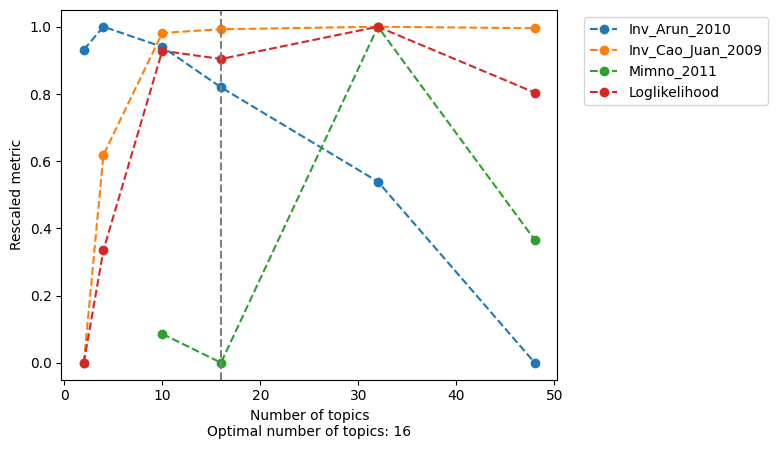

In [2]:
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
_stderr = sys.stderr
null = open(os.devnull,'wb')

import os
work_dir = 'NFYA'
import pycisTopic
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))
tmp_dir = '/temp_work/ch250798/Scenic/tmp2'

models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/10x_NFYA_models_500_iter_LDA.pkl'), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=16,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

In [3]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

2024-03-25 14:02:02,543 cisTopic     INFO     Running UMAP


/home/ch250798/miniconda3/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


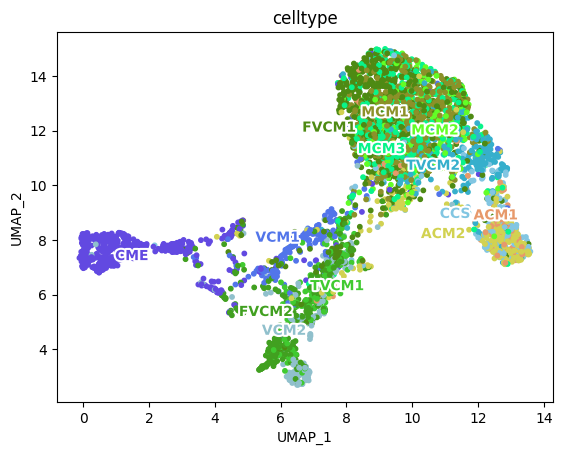

In [4]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target  = 'cell', scale=True)
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['celltype'])

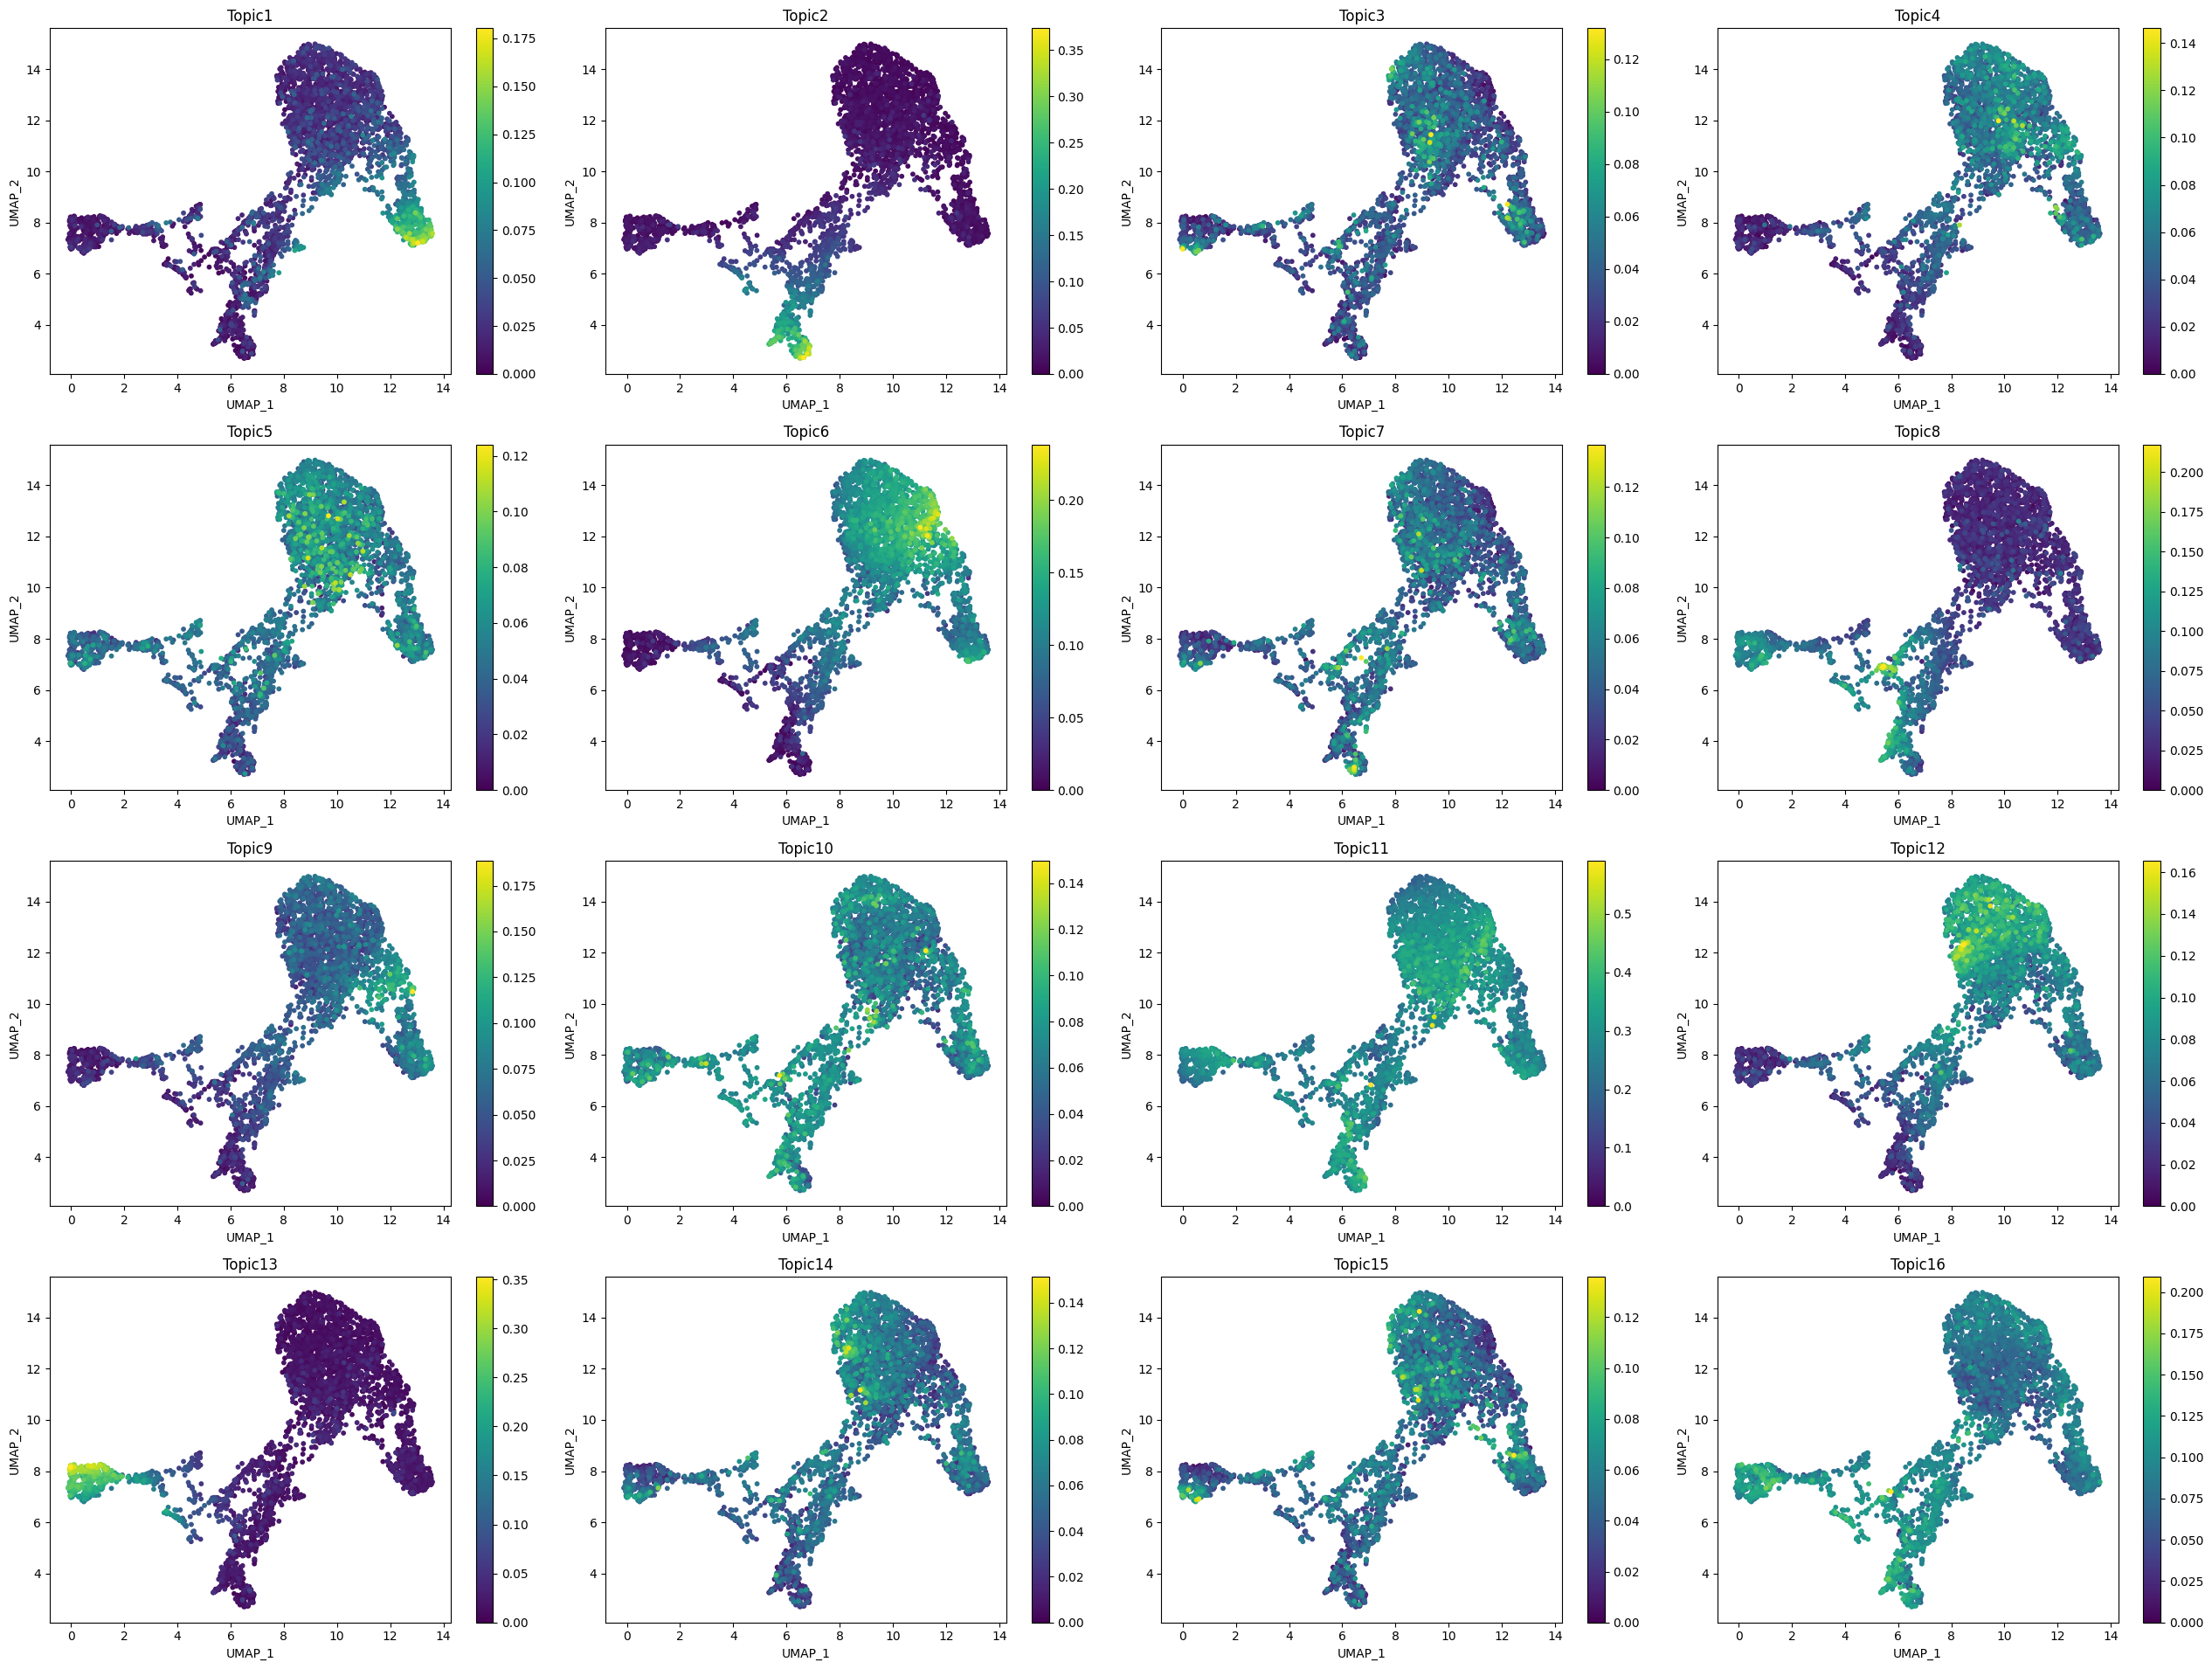

In [5]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 4)

In [6]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='celltype', var_features=variable_regions, split_pattern = '-')

2024-03-25 14:09:29,850 cisTopic     INFO     Imputing region accessibility
2024-03-25 14:09:29,854 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-03-25 14:09:30,823 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-03-25 14:09:31,788 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-03-25 14:09:32,766 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-03-25 14:09:33,748 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-03-25 14:09:34,751 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-03-25 14:09:35,802 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-03-25 14:09:36,748 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2024-03-25 14:09:37,710 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2024-03-25 14:09:38,751 cisTopic     

<Figure size 640x480 with 0 Axes>

In [8]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))

In [9]:
print(markers_dict) 

{'ACM1':                             Log2FC  Adjusted_pval Contrast
chr17:51446086-51446586   1.905478   1.152579e-41     ACM1
chr3:154561448-154561948  1.904024   1.677585e-41     ACM1
chr17:87872341-87872841   1.890820   1.162057e-41     ACM1
chr2:13124635-13125135    1.882532   1.026387e-41     ACM1
chr16:92731665-92732165   1.882532   1.026387e-41     ACM1
...                            ...            ...      ...
chr2:68896112-68896612    0.585648   3.100072e-35     ACM1
chr2:156780968-156781468  0.585252   2.488249e-32     ACM1
chr1:34677878-34678378    0.585233   4.818808e-31     ACM1
chr19:44723816-44724316   0.585200   8.700426e-20     ACM1
chr1:87856797-87857297    0.585177   1.278628e-17     ACM1

[7408 rows x 3 columns], 'ACM2':                              Log2FC  Adjusted_pval Contrast
chr3:154561448-154561948   2.321265  4.002313e-145     ACM2
chr17:51446086-51446586    2.298709  8.323164e-145     ACM2
chr17:87872341-87872841    2.279239  4.279711e-145     ACM2
chr9:4980

In [10]:
for DAR in markers_dict.keys():
    regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    if len(regions) == 0:
      print(DAR)

In [11]:
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
region_sets['DARs'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict.keys():
    regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    if len(regions) > 0:
        region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))

In [12]:
for key in region_sets.keys():
    print(f'{key}: {region_sets[key].keys()}')

topics_otsu: dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
topics_top_3: dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
DARs: dict_keys(['ACM1', 'ACM2', 'CCS', 'CME', 'FVCM1', 'FVCM2', 'MCM1', 'MCM2', 'MCM3', 'TVCM1', 'TVCM2', 'VCM1', 'VCM2'])


In [13]:
region_sets['DARs']

{'ACM1': +--------------+-----------+-----------+
 | Chromosome   | Start     | End       |
 | (category)   | (int64)   | (int64)   |
 |--------------+-----------+-----------|
 | chr1         | 129483157 | 129483657 |
 | chr1         | 183531357 | 183531857 |
 | chr1         | 116099449 | 116099949 |
 | chr1         | 127674007 | 127674507 |
 | ...          | ...       | ...       |
 | chrX         | 38811228  | 38811728  |
 | chrX         | 100738870 | 100739370 |
 | chrX         | 142838654 | 142839154 |
 | chrX         | 168647735 | 168648235 |
 +--------------+-----------+-----------+
 Unstranded PyRanges object has 7,408 rows and 3 columns from 20 chromosomes.
 For printing, the PyRanges was sorted on Chromosome.,
 'ACM2': +--------------+-----------+-----------+
 | Chromosome   | Start     | End       |
 | (category)   | (int64)   | (int64)   |
 |--------------+-----------+-----------|
 | chr1         | 129483157 | 129483657 |
 | chr1         | 183531357 | 183531857 |
 | chr1    

In [ ]:
##remove clusters CD14-Mono, MPP Ribo-high, MPP SPINK2-CD99

#adata_filtered = adata[adata.obs['celltype'] != '2' ] #MPP Ribo-high
#adata_filtered = adata_filtered[adata_filtered.obs['cell_type'] != 'CD14-Mono' ] #CD14-Mono
#adata_filtered = adata_filtered[adata_filtered.obs['cell_type'] != 'MPP SPINK2-CD99' ] #MPP SPINK2-CD99
#adata_filtered.obs.cell_type
#adata = adata_filtered ##replace original adata with filtered one
#del(adata_filtered)


In [ ]:
#sbatch run_AFmultiomeN_2.sh